In [ ]:
#!pip install seaborn plotly kaleido matplotlib_venn rdkit

In [2]:
from typing import List

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.manifold import TSNE
from matplotlib_venn import venn3
from plotly_upset.plotting import plot_upset
import plotly.graph_objects as go

warnings.filterwarnings('ignore')

### Load the data

In [3]:
## hERG
data_herg_dev = pd.read_csv("../data/hERG/data_herg_dev.csv")
eval_herg_set_60 = pd.read_csv("../data/hERG/eval_set_herg_60.csv")
eval_herg_set_70 = pd.read_csv("../data/hERG/eval_set_herg_70.csv")
## Nav1.5
data_nav_dev = pd.read_csv("../data/Nav1.5/data_nav_dev.csv")
eval_nav_set_60 = pd.read_csv("../data/Nav1.5/eval_set_nav_60.csv")
eval_nav_set_70 = pd.read_csv("../data/Nav1.5/eval_set_nav_70.csv")
## Cav1.2
data_cav_dev = pd.read_csv("../data/Cav1.2/data_cav_dev.csv")
eval_cav_set_60 = pd.read_csv("../data/Cav1.2/eval_set_cav_60.csv")
eval_cav_set_70 = pd.read_csv("../data/Cav1.2/eval_set_cav_70.csv")

In [4]:
herg_ssl_dev = pd.read_csv("../data/hERG/herg_unlabeled_data.csv")
nav_ssl_dev = pd.read_csv("../data/Nav1.5/nav_unlabeled_data.csv")
cav_ssl_dev = pd.read_csv("../data/Cav1.2/cav_unlabeled_data.csv")

### Utils

In [26]:
def compute_fingerprint_features(smiles_list: List[str]) -> np.ndarray:
    """
    Compute ECFP2 & PubChem fingerprint features for a list
    of SMILES strings

    Parameters
    ----------
    smiles_list: List[str]
        The list of SMILES strings.

    Returns
    -------
    np.ndarray
        Returns a 2D numpy array, where each row corrsponds
        to the fingerprints of a SMILES strings in order.
    """
    molecular_mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]
    # Initialize an array to store ECFP2 & PubChem fingerprint features
    features = np.zeros((len(smiles_list), 1024 + 881), dtype=np.int32)

    for i, mol in enumerate(molecular_mols):
        ECFP2_mol_fingerprint = CalculateECFP2Fingerprint(mol)
        pubchem_mol_fingerprint = CalculatePubChemFingerprint(mol)
        numerical_representation = np.concatenate(
            (ECFP2_mol_fingerprint[0], pubchem_mol_fingerprint)
        )
        features[i] = numerical_representation

    return features

### Tanimoto similarity

In [ ]:
## Generate fingerprints for hERG
herg_ssl_dev["mol_object"] = herg_ssl_dev.apply(lambda x: Chem.MolFromSmiles(x["SMILES"],sanitize=True), axis = 1)
herg_ssl_dev["Fingerprint"] = herg_ssl_dev.apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x["mol_object"], 2, nBits=2048), axis = 1)
## Generate fingerprints for Cav1.2
cav_ssl_dev["mol_object"] = cav_ssl_dev.apply(lambda x: Chem.MolFromSmiles(x["SMILES"],sanitize=True), axis = 1)
cav_ssl_dev["Fingerprint"] = cav_ssl_dev.apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x["mol_object"], 2, nBits=2048), axis = 1)
## Generate fingerprints for Nav1.5
nav_ssl_dev["mol_object"] = nav_ssl_dev.apply(lambda x: Chem.MolFromSmiles(x["SMILES"],sanitize=True), axis = 1)
nav_ssl_dev["Fingerprint"] = nav_ssl_dev.apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x["mol_object"], 2, nBits=2048), axis = 1)

[10:42:37] WARNING: not removing hydrogen atom without neighbors
[10:43:10] WARNING: not removing hydrogen atom without neighbors


In [ ]:
## Generate fingerprints for hERG Eval
eval_herg_set_70["mol_object"] = eval_herg_set_70.apply(lambda x: Chem.MolFromSmiles(x["SMILES"],sanitize=True), axis = 1)
eval_herg_set_70["Fingerprint"] = eval_herg_set_70.apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x["mol_object"], 2, nBits=2048), axis = 1)
eval_herg_set_60["mol_object"] = eval_herg_set_60.apply(lambda x: Chem.MolFromSmiles(x["SMILES"],sanitize=True), axis = 1)
eval_herg_set_60["Fingerprint"] = eval_herg_set_60.apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x["mol_object"], 2, nBits=2048), axis = 1)
## Generate fingerprints for Cav1.2 Eval
eval_cav_set_70["mol_object"] = eval_cav_set_70.apply(lambda x: Chem.MolFromSmiles(x["SMILES"],sanitize=True), axis = 1)
eval_cav_set_70["Fingerprint"] = eval_cav_set_70.apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x["mol_object"], 2, nBits=2048), axis = 1)
eval_cav_set_60["mol_object"] = eval_cav_set_60.apply(lambda x: Chem.MolFromSmiles(x["SMILES"],sanitize=True), axis = 1)
eval_cav_set_60["Fingerprint"] = eval_cav_set_60.apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x["mol_object"], 2, nBits=2048), axis = 1)
## Generate fingerprints for Nav1.5 Eval
eval_nav_set_70["mol_object"] = eval_nav_set_70.apply(lambda x: Chem.MolFromSmiles(x["SMILES"],sanitize=True), axis = 1)
eval_nav_set_70["Fingerprint"] = eval_nav_set_70.apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x["mol_object"], 2, nBits=2048), axis = 1)
eval_nav_set_60["mol_object"] = eval_nav_set_60.apply(lambda x: Chem.MolFromSmiles(x["SMILES"],sanitize=True), axis = 1)
eval_nav_set_60["Fingerprint"] = eval_nav_set_60.apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x["mol_object"], 2, nBits=2048), axis = 1)

In [ ]:
## Compute TanimotoSimilarity for hERG
herg_eval_70_TanimotoSimilarity_dev = []
for fp1 in eval_herg_set_70["Fingerprint"].tolist():
    for fp2 in herg_ssl_dev["Fingerprint"].tolist():
        Tsim = DataStructs.TanimotoSimilarity(fp1, fp2)
        herg_eval_70_TanimotoSimilarity_dev.append(Tsim)
herg_eval_60_TanimotoSimilarity_dev = []
for fp1 in eval_herg_set_60["Fingerprint"].tolist():
    for fp2 in herg_ssl_dev["Fingerprint"].tolist():
        Tsim = DataStructs.TanimotoSimilarity(fp1, fp2)
        herg_eval_60_TanimotoSimilarity_dev.append(Tsim)

In [ ]:
## Compute TanimotoSimilarity for Nav1.5
nav_eval_70_TanimotoSimilarity_dev = []
for fp1 in eval_nav_set_70["Fingerprint"].tolist():
    for fp2 in nav_ssl_dev["Fingerprint"].tolist():
        Tsim = DataStructs.TanimotoSimilarity(fp1, fp2)
        nav_eval_70_TanimotoSimilarity_dev.append(Tsim)
nav_eval_60_TanimotoSimilarity_dev = []
for fp1 in eval_nav_set_60["Fingerprint"].tolist():
    for fp2 in nav_ssl_dev["Fingerprint"].tolist():
        Tsim = DataStructs.TanimotoSimilarity(fp1, fp2)
        nav_eval_60_TanimotoSimilarity_dev.append(Tsim)

In [ ]:
## Compute TanimotoSimilarity for Cav1.2
cav_eval_70_TanimotoSimilarity_dev = []
for fp1 in eval_cav_set_70["Fingerprint"].tolist():
    for fp2 in cav_ssl_dev["Fingerprint"].tolist():
        Tsim = DataStructs.TanimotoSimilarity(fp1, fp2)
        cav_eval_70_TanimotoSimilarity_dev.append(Tsim)
cav_eval_60_TanimotoSimilarity_dev = []
for fp1 in eval_cav_set_60["Fingerprint"].tolist():
    for fp2 in cav_ssl_dev["Fingerprint"].tolist():
        Tsim = DataStructs.TanimotoSimilarity(fp1, fp2)
        cav_eval_60_TanimotoSimilarity_dev.append(Tsim)

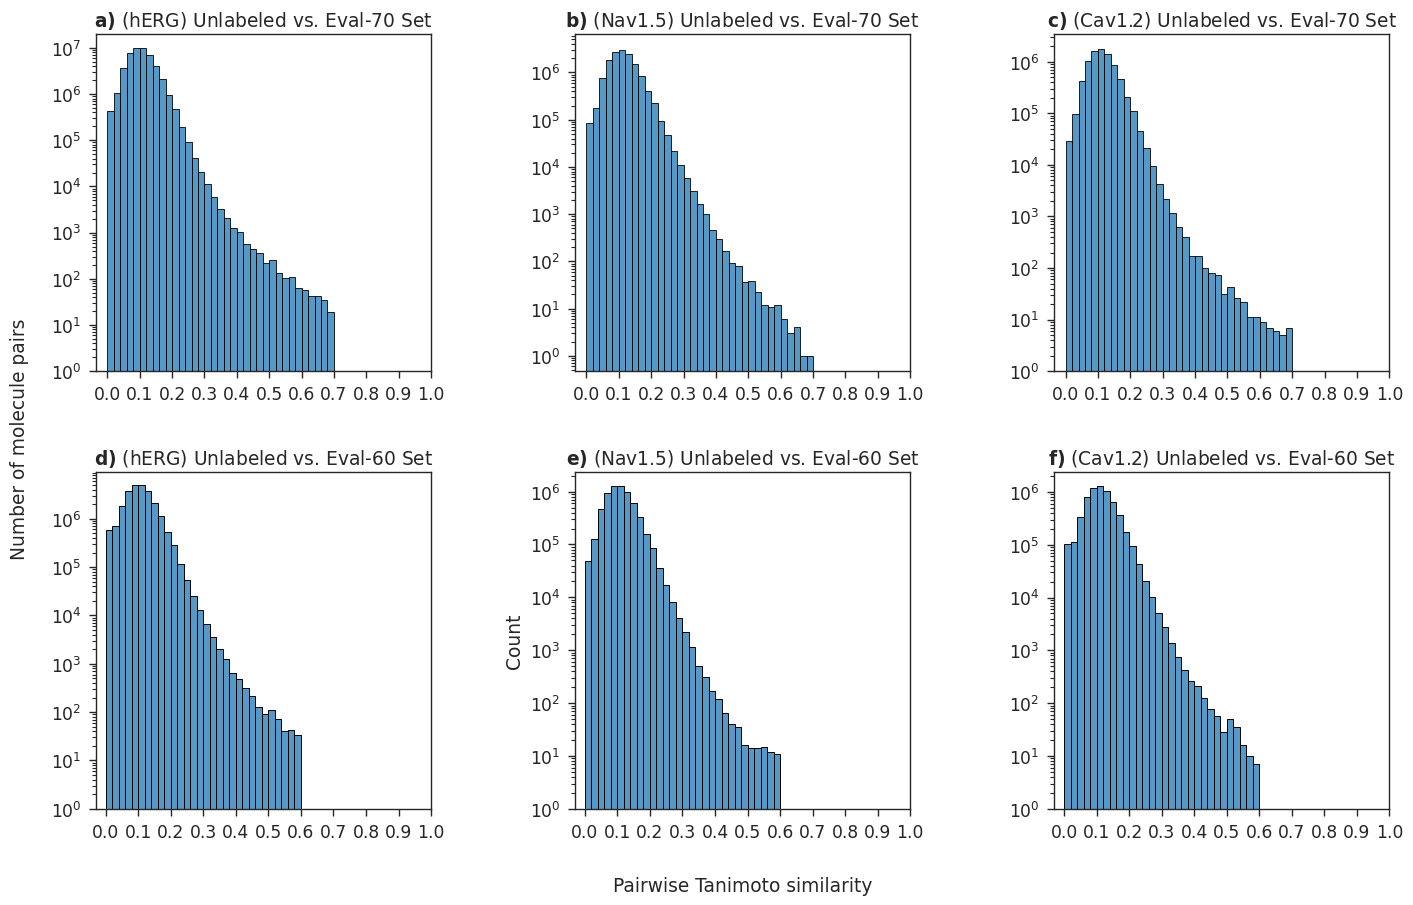

In [ ]:
## plot external evaluation set Tanimoto Similarity distribution
plt.style.use(['seaborn-v0_8-white', 'seaborn-v0_8-paper'])
sns.set_context('paper', font_scale=1.4)    # Single-column figure.
width = 14
height = width / 1.618
fig,  axes = plt.subplots(2,3,figsize=(width, height))

#ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flatten()

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

g1 = sns.histplot(herg_eval_70_TanimotoSimilarity_dev,fill=True, binwidth=0.02, ax=ax1)
g2 = sns.histplot(nav_eval_70_TanimotoSimilarity_dev,fill=True, binwidth=0.02, ax=ax2)
g3 = sns.histplot(cav_eval_70_TanimotoSimilarity_dev,fill=True, binwidth=0.02, ax=ax3)
g4 = sns.histplot(herg_eval_60_TanimotoSimilarity_dev,fill=True, binwidth=0.02, ax=ax4)
g5 = sns.histplot(nav_eval_60_TanimotoSimilarity_dev,fill=True, binwidth=0.02, ax=ax5)
g6 = sns.histplot(cav_eval_60_TanimotoSimilarity_dev,fill=True, binwidth=0.02, ax=ax6)
#g7 = sns.histplot(herg_eval_60_TanimotoSimilarity_eval_70,fill=True, binwidth=0.02, ax=ax7)
#g8 = sns.histplot(nav_eval_60_TanimotoSimilarity_eval_70,fill=True, binwidth=0.02, ax=ax8)
#g9 = sns.histplot(cav_eval_60_TanimotoSimilarity_eval_70,fill=True, binwidth=0.02, ax=ax9)
fig.tight_layout()
ax1.title.set_text('$\\mathbf{a)}$ (hERG) Unlabeled vs. Eval-70 Set')
ax1.set_ylabel('')
g1.set(yscale="log")
ax2.set_ylabel('')
ax2.title.set_text('$\\mathbf{b)}$ (Nav1.5) Unlabeled vs. Eval-70 Set')
g2.set(yscale="log")
ax3.title.set_text('$\\mathbf{c)}$ (Cav1.2) Unlabeled vs. Eval-70 Set')
ax3.set_ylabel('')
g3.set(yscale="log")
ax4.title.set_text('$\\mathbf{d)}$ (hERG) Unlabeled vs. Eval-60 Set')
ax4.set_ylabel('Number of molecule pairs', labelpad=25)
ax4.yaxis.set_label_coords(-0.2, 1.1)
g4.set(yscale="log")
ax5.title.set_text('$\\mathbf{e)}$ (Nav1.5) Unlabeled vs. Eval-60 Set')
ax5.set_xlabel('Pairwise Tanimoto similarity', labelpad=25)
g5.set(yscale="log")
ax6.set_ylabel('')
ax6.title.set_text('$\\mathbf{f)}$ (Cav1.2) Unlabeled vs. Eval-60 Set')
g6.set(yscale="log")

plt.setp([ax1], 
         xticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
         yticks=[1, 10, 100, 1000, 10000, 100000, 1000000, 10000000])

plt.setp([ax2,ax3,ax4,ax5,ax6], 
         xticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
         yticks=[1, 10, 100, 1000, 10000, 100000, 1000000])
# Add space between subplots
plt.subplots_adjust(wspace=0.43, hspace=0.3)
# Plot
plt.show()

### I.I.D

In [ ]:
data_herg = pd.concat([data_herg_dev,eval_herg_set_60,eval_herg_set_70])
data_nav = pd.concat([data_nav_dev,eval_nav_set_60,eval_nav_set_70])
data_cav = pd.concat([data_cav_dev,eval_cav_set_60,eval_cav_set_70])

In [ ]:
# hERG
eval_herg_set_60['label'] = 'Evaluation set-60'
eval_herg_set_70['label'] = 'Evaluation set-70'
data_herg_dev['label'] = 'Labeled'
herg_ssl_dev['label'] = 'Unlabeled'
all_herg_labels = pd.concat([herg_ssl_dev, data_herg_dev, eval_herg_set_60, eval_herg_set_70])
# Nav1.5
eval_nav_set_60['label'] = 'Evaluation set-60'
eval_nav_set_70['label'] = 'Evaluation set-70'
data_nav_dev['label'] = 'Labeled'
nav_ssl_dev['label'] = 'Unlabeled'
all_nav_labels = pd.concat([nav_ssl_dev, data_nav_dev, eval_nav_set_60, eval_nav_set_70])
# Cav1.2
eval_cav_set_60['label'] = 'Evaluation set-60'
eval_cav_set_70['label'] = 'Evaluation set-70'
data_cav_dev['label'] = 'Labeled'
cav_ssl_dev['label'] = 'Unlabeled'
all_cav_labels = pd.concat([cav_ssl_dev, data_cav_dev, eval_cav_set_60, eval_cav_set_70])

In [ ]:
tsne_herg_model = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_embedding_herg = tsne_model.fit_transform(compute_fingerprint_features(data_herg['SMILES'].tolist()))

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

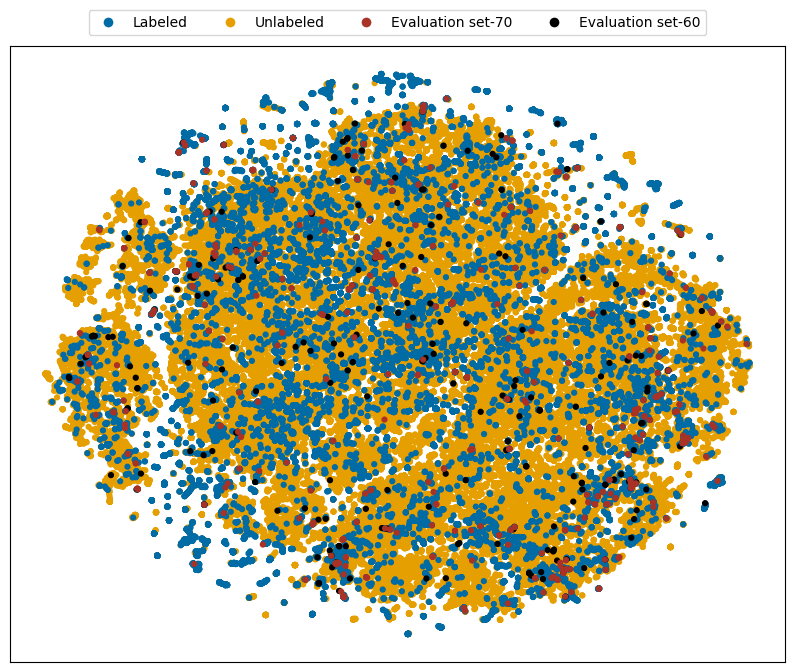

In [ ]:
label_mapping = {'Labeled': ('Labeled', '#006BA4'),'Unlabeled': ('Unlabeled', '#E69F00'),  'Evaluation set-70': ('Evaluation set-70', '#A93226'), 'Evaluation set-60': ('Evaluation set-60', 'black')}
all_herg_labels['label'], colors = zip(*all_herg_labels['label'].map(label_mapping))

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_embedding_herg[:, 0], tsne_embedding_herg[:, 1], c=colors, s=12, cmap='cividis')

legend_labels, legend_colors = zip(*label_mapping.values())
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=8, markerfacecolor=color)
                  for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=legend_handles, title='', loc='upper center', bbox_to_anchor=(0.5, 1.07), ncol=4)

# Remove axis ticks
plt.xticks([])
plt.yticks([])

plt.show()

In [ ]:
tsne_nav_model = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_embedding_nav = tsne_nav_model.fit_transform(compute_fingerprint_features(data_nav['SMILES'].tolist()))

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

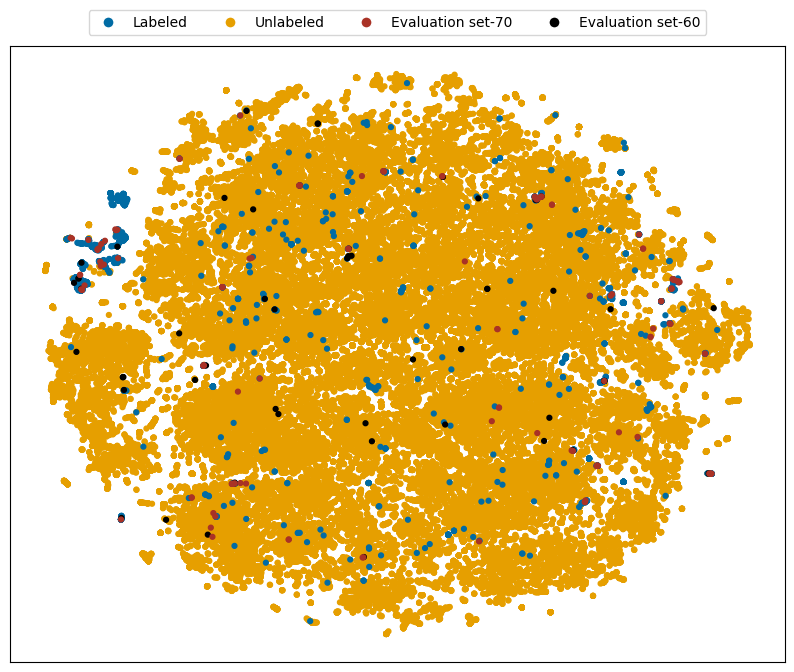

In [ ]:
label_mapping = {'Labeled': ('Labeled', '#006BA4'),'Unlabeled': ('Unlabeled', '#E69F00'),  'Evaluation set-70': ('Evaluation set-70', '#A93226'), 'Evaluation set-60': ('Evaluation set-60', 'black')}
all_nav_labels['label'], colors = zip(*all_nav_labels['label'].map(label_mapping))

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_embedding_nav[:, 0], tsne_embedding_nav[:, 1], c=colors, s=12, cmap='cividis')

legend_labels, legend_colors = zip(*label_mapping.values())
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=8, markerfacecolor=color)
                  for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=legend_handles, title='', loc='upper center', bbox_to_anchor=(0.5, 1.07), ncol=4)

# Remove axis ticks
plt.xticks([])
plt.yticks([])

plt.show()

In [ ]:
tsne_cav_model = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_embedding_cav = tsne_cav_model.fit_transform(compute_fingerprint_features(data_cav['SMILES'].tolist()))

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

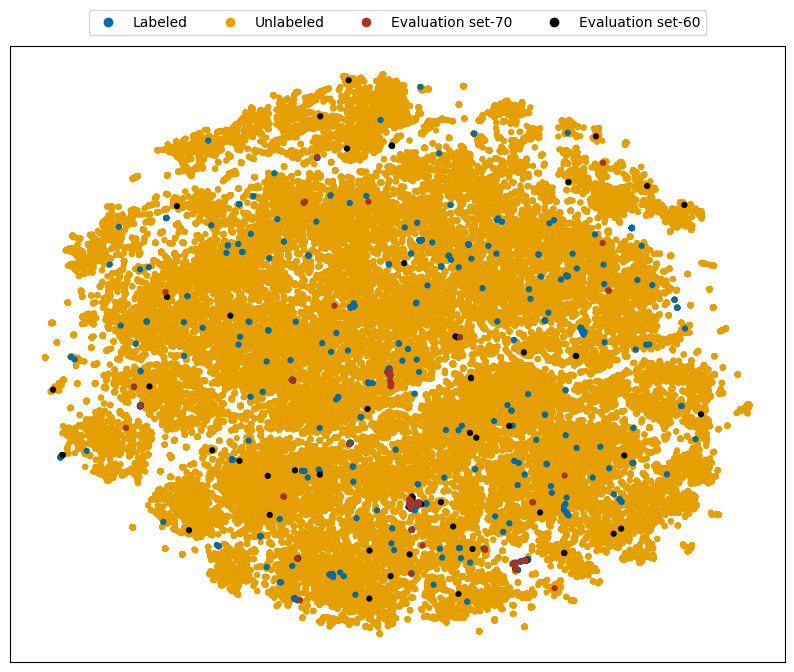

In [ ]:
label_mapping = {'Labeled': ('Labeled', '#006BA4'),'Unlabeled': ('Unlabeled', '#E69F00'),  'Evaluation set-70': ('Evaluation set-70', '#A93226'), 'Evaluation set-60': ('Evaluation set-60', 'black')}
all_cav_labels['label'], colors = zip(*all_cav_labels['label'].map(label_mapping))

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_embedding_cav[:, 0], tsne_embedding_cav[:, 1], c=colors, s=12, cmap='cividis')

legend_labels, legend_colors = zip(*label_mapping.values())
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=8, markerfacecolor=color)
                  for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=legend_handles, title='', loc='upper center', bbox_to_anchor=(0.5, 1.07), ncol=4)

# Remove axis ticks
plt.xticks([])
plt.yticks([])

plt.show()

### CToxPred2 vs CardioGenAI

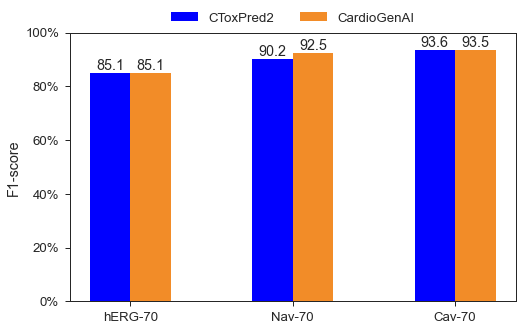

In [44]:
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(x[i], y[i], y[i], ha='center', va='bottom')

# Plotting config.
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_context('paper', font_scale=1.5)

width = 8
height = width / 1.618
fig, ax = plt.subplots(figsize=(width, height))

methods = ['hERG-70', 'Nav-70', 'Cav-70']
values1 = [85.1, 90.2, 93.6]  
values2 = [85.1, 92.5, 93.5]  

index = np.arange(len(methods))
bar_width = 0.25

ax.set_ylabel('F1-score')
#ax.set_xlabel('Test set')
ax.bar(index - bar_width/2, values1, bar_width, color='b', hatch='', label='CToxPred2')
ax.bar(index + bar_width/2, values2, bar_width, color='#F28C28', hatch='', label='CardioGenAI')

addlabels(index - bar_width/2, values1)
addlabels(index + bar_width/2, values2)

plt.xticks(index, methods)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=None, symbol='%', is_latex=False))
ax.set_ylim([0, 100])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=2)
#plt.show()
plt.savefig('bench_70.png', dpi=600, bbox_inches='tight')

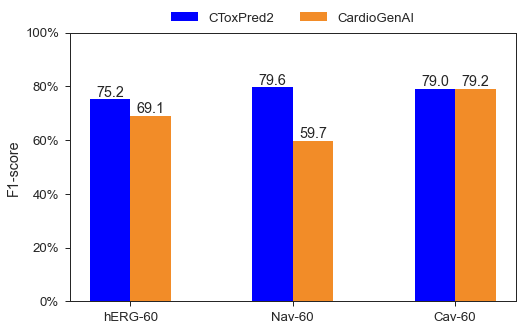

In [46]:
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(x[i], y[i], y[i], ha='center', va='bottom')

# Plotting config.
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_context('paper', font_scale=1.5)

width = 8
height = width / 1.618
fig, ax = plt.subplots(figsize=(width, height))

methods = ['hERG-60', 'Nav-60', 'Cav-60']
values1 = [75.2, 79.6, 79.0]  
values2 = [69.1, 59.7, 79.2]  

index = np.arange(len(methods))
bar_width = 0.25

ax.set_ylabel('F1-score')
#ax.set_xlabel('Test set')
ax.bar(index - bar_width/2, values1, bar_width, color='b', hatch='', label='CToxPred2')
ax.bar(index + bar_width/2, values2, bar_width, color='#F28C28', hatch='', label='CardioGenAI')

addlabels(index - bar_width/2, values1)
addlabels(index + bar_width/2, values2)

plt.xticks(index, methods)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=None, symbol='%', is_latex=False))
#ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim([0, 100])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=2)
#plt.show()
plt.savefig('bench_60.pdf', dpi=600, bbox_inches='tight')

### Labeled data analysis

In [13]:
all_collected = pd.read_csv("../data/analyzed_sets/small_molecule_library_store_carditoxicity_predictions.csv")

In [14]:
data_herg = pd.concat([data_herg_dev,eval_herg_set_60,eval_herg_set_70])
data_nav = pd.concat([data_nav_dev,eval_nav_set_60,eval_nav_set_70])
data_cav = pd.concat([data_cav_dev,eval_cav_set_60,eval_cav_set_70])

In [15]:
all_labeled = pd.concat([data_herg,data_nav, data_cav])
all_labeled_keys = all_labeled['InChI Key'].unique().tolist()
all_labeled = all_collected[all_collected['InChI_Key'].isin(all_labeled_keys)]

In [16]:
# hERG
all_labeled_herg = all_labeled
all_labeled_herg = all_labeled_herg[(all_labeled_herg['hERG_Inhibition'] == 1) & (all_labeled_herg['hERG_Inhibition_confidence'] >= 0.9 )]
# Nav1.5
all_labeled_nav = all_labeled
all_labeled_nav = all_labeled_nav[(all_labeled_nav['Nav_Inhibition'] == 1) & (all_labeled_nav['Nav_Inhibition_confidence'] >= 0.9 )]
# Cav1.2
all_labeled_cav = all_labeled
all_labeled_cav = all_labeled_cav[(all_labeled_cav['Cav_Inhibition'] == 1) & (all_labeled_cav['Cav_Inhibition_confidence'] >= 0.9 )]

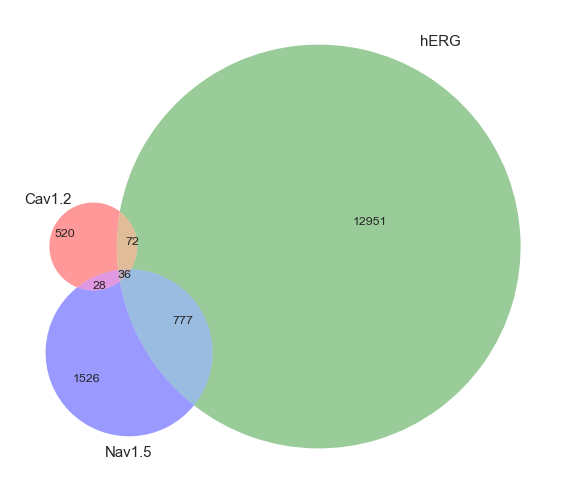

In [17]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_context('paper', font_scale=1.3)

height = 16
width = height / 1.618
fig, ax = plt.subplots(figsize=(width, height))

venn3([set(all_labeled_cav['InChI_Key']), set(all_labeled_herg['InChI_Key']),set(all_labeled_nav['InChI_Key'])], set_labels = ('Cav1.2','hERG','Nav1.5'))
plt.show()

In [18]:
total_compounds = all_labeled['InChI_Key'].nunique()
inhibitors_percentage_dict = {'only hERG inhibitors' : [12951 / total_compounds],
                    'only Nav1.5 inhibitors' : [1526 / total_compounds],
                    'only Cav1.2 inhibitors' : [520 / total_compounds],
                    'hERG & Nav1.5 inhibitors' : [(777 + 36) / total_compounds],
                    'hERG & Cav1.2 inhibitors' : [(72 + 36) / total_compounds],
                    'Nav1.5 & Cav1.2 inhibitors' : [(28 + 36) / total_compounds],
                    'hERG & Nav1.5 & Cav1.2 inhibitors' : [36 / total_compounds],
                    'all hERG inhibitors' : [(12951 + 777 + 72 + 36) / total_compounds],
                    'all Nav1.5 inhibitors' : [(1526 + 777 + 28 + 36) / total_compounds],
                    'all Cav1.2 inhibitors' : [(520 + 72 + 28 + 36) / total_compounds]}

inhibitors_distribution = pd.DataFrame(inhibitors_percentage_dict)
inhibitors_distribution = inhibitors_distribution.apply(lambda x: x * 100)

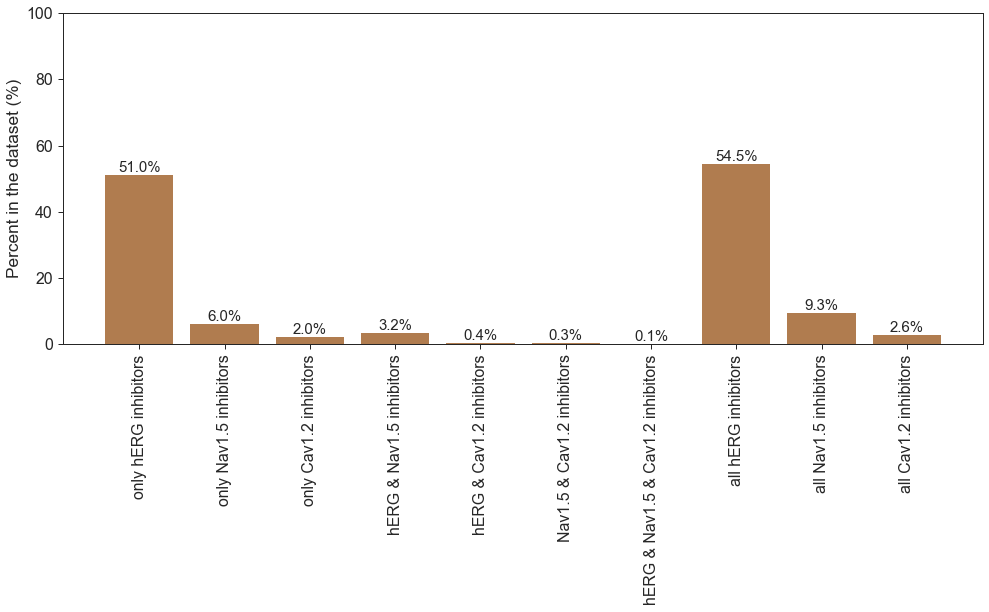

In [20]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_context('paper', font_scale=1.8)
plt.figure(figsize=(14, 14/1.6))
plt.rcParams.update({'font.size': 15})
ax = plt.axes()

# Bar plot
bars = plt.bar(inhibitors_distribution.columns.tolist(), inhibitors_distribution.values.flatten(), color='#B07C4F')

# Add values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{round(yval, 1)}%', va='bottom', ha='center')

plt.xlabel('')
plt.ylabel('Percent in the dataset (%)')
plt.xticks(rotation=90)
ax.set_ylim([0, 100]) 
plt.tight_layout()
plt.show()

In [21]:
_nav_blockers = all_labeled_nav['InChI_Key'].tolist()
_cav_blockers = all_labeled_cav['InChI_Key'].tolist()
_herg_blockers = all_labeled_herg['InChI_Key'].tolist()

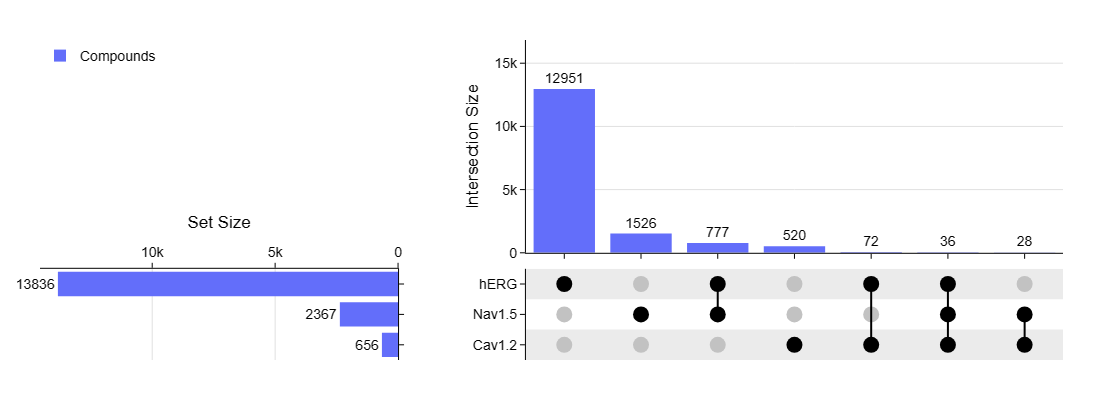

In [22]:
herg = set(_herg_blockers)
nav = set(_nav_blockers)
cav = set(_cav_blockers)

# Create a list containing all unique IDs
all_ids = list(set().union(herg, nav, cav))

# Create a DataFrame with the IDs as the first column
df = pd.DataFrame({'ID': all_ids})

# Add binary columns indicating presence in each set
df['hERG'] = df['ID'].isin(herg).astype(int)
df['Nav1.5'] = df['ID'].isin(nav).astype(int)
df['Cav1.2'] = df['ID'].isin(cav).astype(int)


df = df[['Cav1.2', 'Nav1.5', 'hERG']]

# Plotting
fig = plot_upset(
    dataframes=[df],
    legendgroups=["Compounds"],
    sorted_x="d",
    sorted_y="a",
    marker_size=16
)

fig.update_layout(
    font_family="Arial, sans-serif",
    uniformtext_minsize=14,
    font=dict(size=14)
)

fig.show()

### ChEMBL data analysis

In [23]:
all_collected = pd.read_csv("../data/analyzed_sets/small_molecule_library_store_carditoxicity_predictions.csv")
all_collected_chembl = all_collected[all_collected['Source'] == 'ChEMBL']
# hERG
all_chembl_herg = all_collected_chembl
all_chembl_herg = all_chembl_herg[(all_chembl_herg['hERG_Inhibition'] == 1) & (all_chembl_herg['hERG_Inhibition_confidence'] >= 0.9 )]
# Nav1.5
all_chembl_nav = all_collected_chembl
all_chembl_nav = all_chembl_nav[(all_chembl_nav['Nav_Inhibition'] == 1) & (all_chembl_nav['Nav_Inhibition_confidence'] >= 0.9 )]
# Cav1.2
all_chembl_cav = all_collected_chembl
all_chembl_cav = all_chembl_cav[(all_chembl_cav['Cav_Inhibition'] == 1) & (all_chembl_cav['Cav_Inhibition_confidence'] >= 0.9 )]

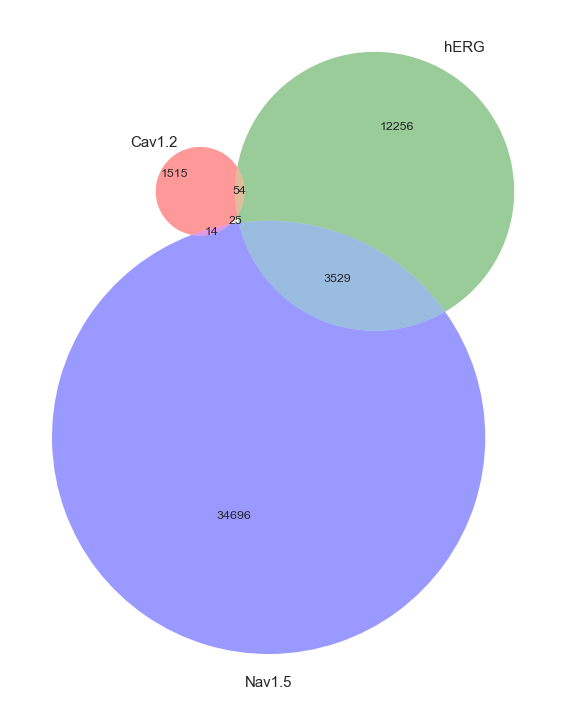

In [24]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_context('paper', font_scale=1.3)

height = 16
width = height / 1.618
fig, ax = plt.subplots(figsize=(width, height))

venn3([set(all_chembl_cav['InChI_Key']), set(all_chembl_herg['InChI_Key']),set(all_chembl_nav['InChI_Key'])], set_labels = ('Cav1.2','hERG','Nav1.5'))
plt.show()

In [25]:
total_compounds = all_collected_chembl['InChI_Key'].nunique()
inhibitors_percentage_dict = {'only hERG inhibitors' : [12256 / total_compounds],
                    'only Nav1.5 inhibitors' : [34696 / total_compounds],
                    'only Cav1.2 inhibitors' : [1515 / total_compounds],
                    'hERG & Nav1.5 inhibitors' : [(3529 + 25) / total_compounds],
                    'hERG & Cav1.2 inhibitors' : [(54 + 25) / total_compounds],
                    'Nav1.5 & Cav1.2 inhibitors' : [(14 + 25) / total_compounds],
                    'hERG & Nav1.5 & Cav1.2 inhibitors' : [25 / total_compounds],
                    'all hERG inhibitors' : [(12256 + 54 + 3529 + 25) / total_compounds],
                    'all Nav1.5 inhibitors' : [(34696 + 14 + 3529 + 25) / total_compounds],
                    'all Cav1.2 inhibitors' : [(1515 + 14 + 54 + 25) / total_compounds]}

inhibitors_distribution = pd.DataFrame(inhibitors_percentage_dict)
inhibitors_distribution = inhibitors_distribution.apply(lambda x: x * 100)

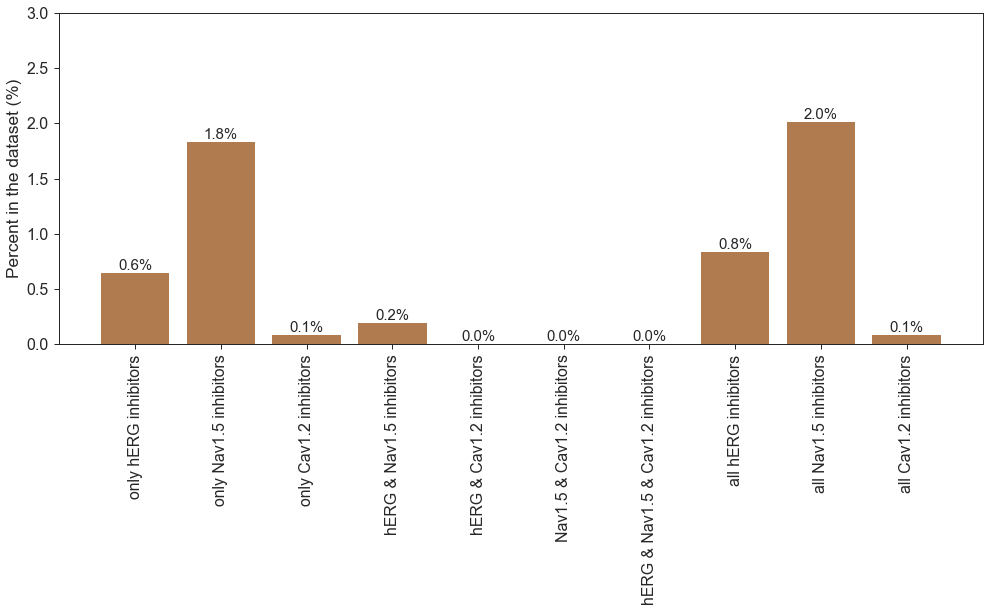

In [27]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_context('paper', font_scale=1.8)
plt.figure(figsize=(14, 14/1.6))
plt.rcParams.update({'font.size': 15})
ax = plt.axes()

# Bar plot
bars = plt.bar(inhibitors_distribution.columns.tolist(), inhibitors_distribution.values.flatten(), color='#B07C4F')

# Add values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{round(yval, 1)}%', va='bottom', ha='center')

plt.xlabel('')
plt.ylabel('Percent in the dataset (%)')
plt.xticks(rotation=90)
ax.set_ylim([0, 3]) 
plt.tight_layout()
plt.show()

In [28]:
_nav_blockers = all_chembl_nav['InChI_Key'].tolist()
_cav_blockers = all_chembl_cav['InChI_Key'].tolist()
_herg_blockers = all_chembl_herg['InChI_Key'].tolist()

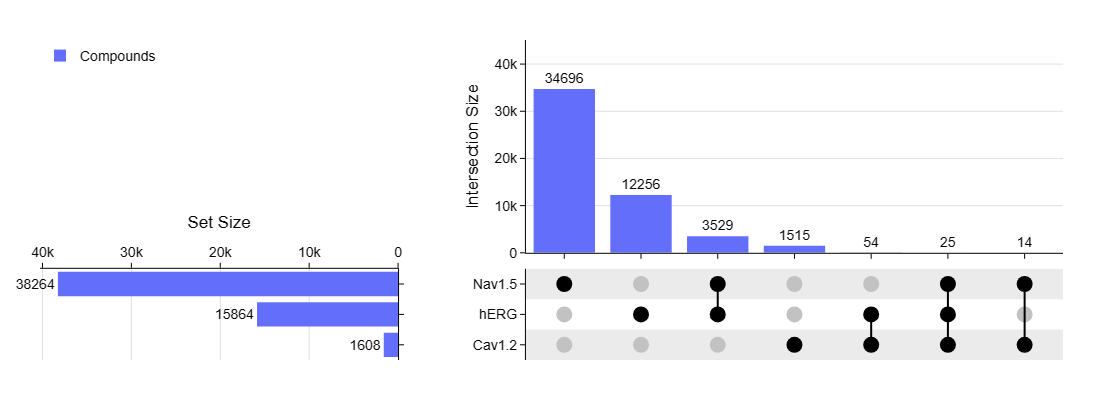

In [29]:
herg = set(_herg_blockers)
nav = set(_nav_blockers)
cav = set(_cav_blockers)

# Create a list containing all unique IDs
all_ids = list(set().union(herg, nav, cav))

# Create a DataFrame with the IDs as the first column
df = pd.DataFrame({'ID': all_ids})

# Add binary columns indicating presence in each set
df['hERG'] = df['ID'].isin(herg).astype(int)
df['Nav1.5'] = df['ID'].isin(nav).astype(int)
df['Cav1.2'] = df['ID'].isin(cav).astype(int)


df = df[['Cav1.2', 'hERG', 'Nav1.5']]

# Plotting
fig = plot_upset(
    dataframes=[df],
    legendgroups=["Compounds"],
    sorted_x="d",
    sorted_y="a",
    marker_size=16
)

fig.update_layout(
    font_family="Arial, sans-serif",
    uniformtext_minsize=14,
    font=dict(size=14)
)

fig.show()

### FDA-approved drugs analysis

In [30]:
predictions = pd.read_csv("../data/analyzed_sets/fda_cardiotoxicity_predictions.csv")
_nav_blockers = predictions[(predictions['Nav1.5'] == 1) & (predictions['Nav1.5_confidence'] >= 90 )]['InChI_Key'].tolist()
_cav_blockers = predictions[(predictions['Cav1.2'] == 1) & (predictions['Cav1.2_confidence'] >= 90 )]['InChI_Key'].tolist()
_herg_blockers = predictions[(predictions['hERG'] == 1) & (predictions['hERG_confidence'] >= 90 )]['InChI_Key'].tolist()

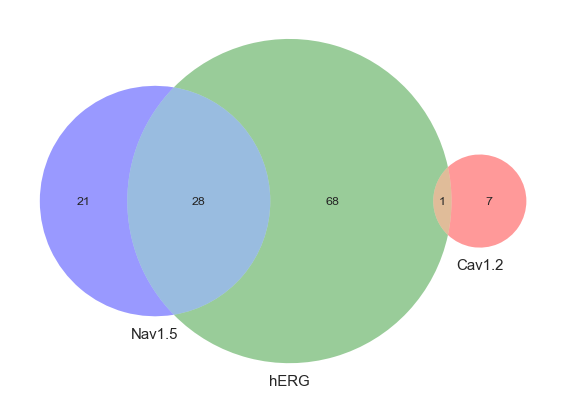

In [31]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_context('paper', font_scale=1.3)

height = 16
width = height / 1.618
fig, ax = plt.subplots(figsize=(width, height))

venn3([set(_cav_blockers), set(_herg_blockers),set(_nav_blockers)], set_labels = ('Cav1.2','hERG','Nav1.5'))
plt.show()

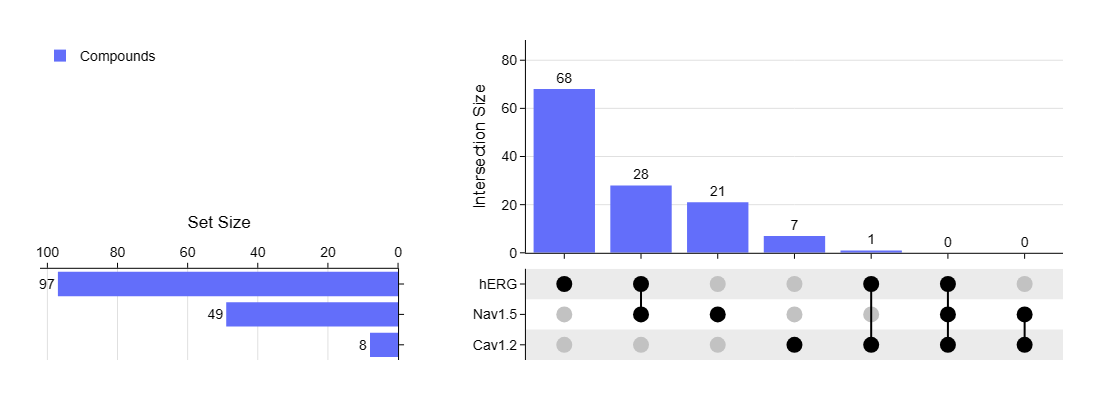

In [34]:
herg = set(_herg_blockers)
nav = set(_nav_blockers)
cav = set(_cav_blockers)

# Create a list containing all unique IDs
all_ids = list(set().union(herg, nav, cav))

# Create a DataFrame with the IDs as the first column
df = pd.DataFrame({'ID': all_ids})

# Add binary columns indicating presence in each set
df['hERG'] = df['ID'].isin(herg).astype(int)
df['Nav1.5'] = df['ID'].isin(nav).astype(int)
df['Cav1.2'] = df['ID'].isin(cav).astype(int)

df = df[['Cav1.2', 'Nav1.5', 'hERG']]

# Plotting
fig = plot_upset(
    dataframes=[df],
    legendgroups=["Compounds"],
    sorted_x="d",
    sorted_y="a",
    marker_size=16
)

fig.update_layout(
    font_family="Arial, sans-serif",
    uniformtext_minsize=14,
    font=dict(size=14)
)

fig.show()

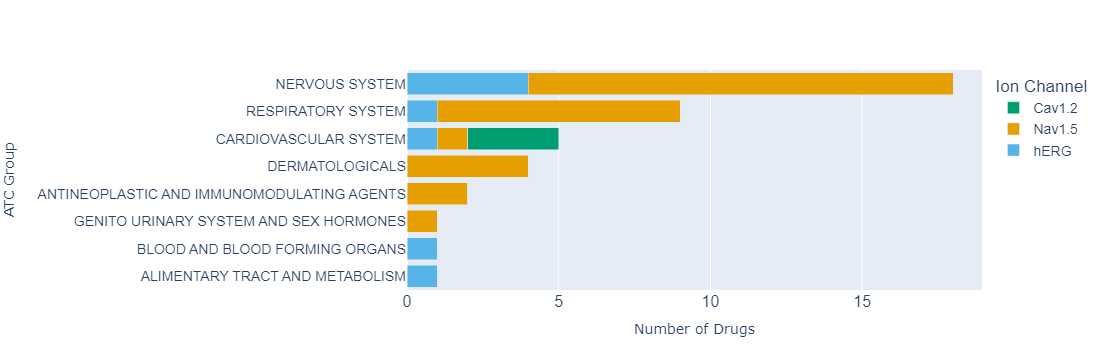

In [33]:
y_herg = [1, 1, 1, 0, 0, 0, 4, 1]
y_nav = [0, 0, 1, 4, 1, 2, 14, 8]
y_cav = [0, 0, 3, 0, 0, 0, 0, 0]

x = ['ALIMENTARY TRACT AND METABOLISM', 
     'BLOOD AND BLOOD FORMING ORGANS', 
     'CARDIOVASCULAR SYSTEM', 
     'DERMATOLOGICALS',
     'GENITO URINARY SYSTEM AND SEX HORMONES', 
     'ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS', 
     'NERVOUS SYSTEM', 
     'RESPIRATORY SYSTEM']

# Calculate stacked values for each category
y_total = [s + n + d for s, n, d in zip(y_herg, y_nav, y_cav)]
y_herg_bottom = [0] * len(y_herg)
y_nav_bottom = y_herg
y_cav_bottom = [s + n for s, n in zip(y_herg, y_nav)]

# Sort the data by the total values
sorted_indices = np.argsort(y_total)
x_sorted = [x[i] for i in sorted_indices]
y_herg_sorted = [y_herg[i] for i in sorted_indices]
y_nav_sorted = [y_nav[i] for i in sorted_indices]
y_cav_sorted = [y_cav[i] for i in sorted_indices]

# Define colorblind-friendly colors
color_palette = ['#56B4E9', '#E69F00', '#009E73']

# Create stacked bar plot for three categories
fig = go.Figure()

fig.add_trace(go.Bar(
    x=y_herg_sorted,
    y=x_sorted,
    name='hERG',
    orientation='h',
    marker=dict(color=color_palette[0]),
    hoverinfo='x',
))

fig.add_trace(go.Bar(
    x=y_nav_sorted,
    y=x_sorted,
    name='Nav1.5',
    orientation='h',
    marker=dict(color=color_palette[1]),
    hoverinfo='x',
))

fig.add_trace(go.Bar(
    x=y_cav_sorted,
    y=x_sorted,
    name='Cav1.2',
    orientation='h',
    marker=dict(color=color_palette[2]),
    hoverinfo='x',
))

# Update layout
fig.update_layout(
    title='',
    xaxis=dict(title='Number of Drugs', tickfont=dict(family='Arial, sans-serif', size=16)),  # Set font to sans serif
    yaxis=dict(title='ATC Group', tickfont=dict(family='Arial, sans-serif', size=14)),  # Set font to sans serif
    barmode='stack',
    legend=dict(title='Ion Channel', font=dict(family='Arial, sans-serif', size=14)),  # Set font to sans serif
    margin=dict(l=100, r=20, t=70, b=70),
)

fig.show()
#fig.write_image('FDA_blockers_ATC_Group_dist.png', scale=4)

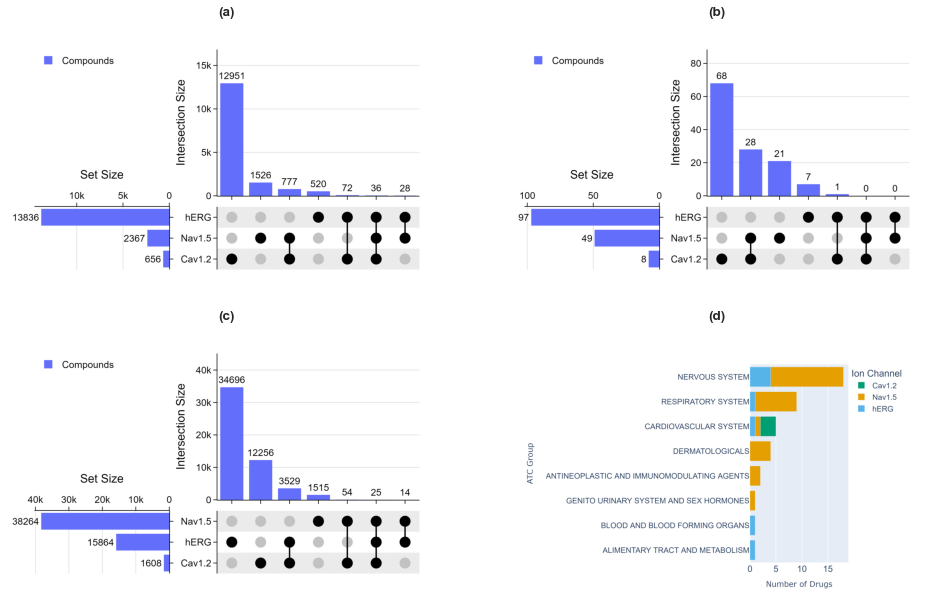

In [36]:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting config.
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_context('paper', font_scale=1.4)

width = 14
height = width / 1.618

# Read the PNG images
image1 = Image.open('figures/other/Labeled_set_blockers.png')
image2 = Image.open('figures/other/FDA_set_blockers.png')
image3 = Image.open('figures/other/ChEMBL_set_blockers.png')
image4 = Image.open('figures/other/FDA_blockers_ATC_Group_dist.png')

# Create a 2x2 grid for displaying images
fig, axs = plt.subplots(2, 2, figsize=(width, height))

# Display image 1
axs[0][0].imshow(image1)
axs[0][0].axis('off')
axs[0][0].set_title('(a)', fontweight='bold')

# Display image 2
axs[0][1].imshow(image2)
axs[0][1].axis('off')
axs[0][1].set_title('(b)', fontweight='bold')

# Display image 2
axs[1][0].imshow(image3)
axs[1][0].axis('off')
axs[1][0].set_title('(c)', fontweight='bold')

# Display image 2
axs[1][1].imshow(image4)
axs[1][1].axis('off')
axs[1][1].set_title('(d)', fontweight='bold')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()